In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
%matplotlib inline
sns.set()
sns.set_context('talk')
plt.rcParams["patch.force_edgecolor"] = False

In [3]:
#calculate gfr
def gfr(seq_num, dem_data, bio_pro):
    user_dem_data = dem_data[dem_data['SEQN'] == seq_num]
    race = user_dem_data['RIDRETH1'].item()
    gender = user_dem_data['RIAGENDR'].item()
    age = user_dem_data['RIDAGEYR'].item()
    sc = bio_pro[bio_pro['SEQN'] == seq_num]['LBXSCR'].item()
    k = 0.7 if gender == 1 else 0.9
    a = -0.329 if gender == 1 else -0.411
    t = 1.159 if race == 4 else 1
    s = 1.018 if gender == 1 else 1
    return 141 * (min(sc/k, 1)**a) * (max(sc/k, 1)**-1.209) * (0.993**age) * s * t

In [4]:
def load_gfr(folder):
    bio_pro = pd.read_sas(folder + '/P_BIOPRO.XPT')
    dem_data = pd.read_sas(folder + '/P_DEMO.XPT')
    gfr_col = bio_pro['SEQN'].apply(lambda seqn: gfr(seqn, dem_data, bio_pro))
    gfr_data = pd.concat([bio_pro['SEQN'],gfr_col], axis=1, join='inner')
    gfr_data.columns = ['SEQN', 'GFR']
    print('Number of patients with possible kidney disease: ', np.count_nonzero(gfr_col <= 60))
    return gfr_data #add gfr to dataset

In [5]:
#build dataset
#folder is the data directory, single_cols is a dict which maps file names with a list of specific cols for that file (for example, from P_KIQ_U.XPT we only want KIQ022 so specific_cols = {'P_KIQ_U.XPT' : ['KIQ022']}
def load_and_merge(folder, specific_cols=None):
    gfr_data = load_gfr(folder)
    data_files = [gfr_data]
    for filename in os.listdir(folder):
        filepath = folder + '/' + filename
        if specific_cols and filename in specific_cols:
            #Add SEQN to cols
            col_names = ['SEQN']
            col_names.extend(specific_cols[filename])
            #Rebuild as dataframe with the correct column names (necessary for the inner join after all data files are collected)
            data_files.append(pd.DataFrame(pd.read_sas(filepath)[col_names], columns=col_names))
        else:
            data_files.append(pd.read_sas(filepath))
    #https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns
    return pd.concat(
        (iDF.set_index('SEQN') for iDF in data_files),
        axis=1, join='inner'
    ).reset_index()

In [6]:
all_years = []
for year_range in ['2017-2020', '2015-2016', '2013-2014', '2011-2012', '2009-2010']:
    full_data = load_and_merge('data/' + year_range, {'KIQ_U.XPT' : ['KIQ022'], 'ALB_CR.XPT' : ['URDACT']})
    all_years.append(full_data)

Number of patients with possible kidney disease:  1252
Number of patients with possible kidney disease:  718
Number of patients with possible kidney disease:  793
Number of patients with possible kidney disease:  695
Number of patients with possible kidney disease:  875


In [7]:
#combine datasets into main dataset
dataset = pd.concat(all_years)

In [8]:
#refine features
data = dataset[['LBXSBU', 'LBXSIR', 'LBXSTP', 'LBXTC', 'LBXSUA', 'LBXBPB', 'LBXBCD', 'LBXTHG', 'LBXBSE', 'LBXBMN', 'URXUBA', 'URXUCD', 'URXUCO', 'URXUCS', 'URXUMO', 'URXUMN', 'URXUPB', 'URXUSB', 'URXUSN', 'URXUTL', 'URXUTU', 'LBXGH', 'LBXIN', 'KIQ022', 'GFR', 'URDACT']]
delete = data[data['KIQ022'] == 9].index
data = data.drop(delete)
data['TARGET'] = data.apply(lambda row: row.GFR >= 60 and row.URDACT >= 30, axis=1)
data = data.dropna()
data = data.drop_duplicates()

<AxesSubplot:xlabel='TARGET', ylabel='count'>

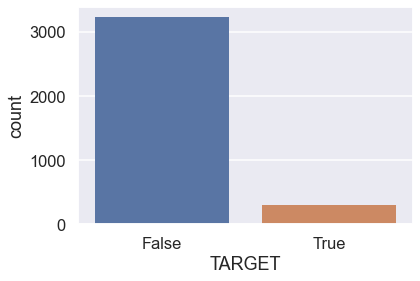

In [9]:
data['KIQ022'].value_counts()
sns.countplot(x='TARGET', data=data)

In [10]:
#data preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(data.drop(['TARGET'], axis=1))
y = data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:

from statistics import mean
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# define model
model = LogisticRegression()
# evaluate mode
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))


Mean ROC AUC: 0.711


In [12]:
# define model
model = LogisticRegression(class_weight='balanced')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.754


In [13]:
#from imblearn.over_sampling import SMOTE
#os = SMOTE(random_state=0)
#columns = data.drop('TARGET', axis=1).columns
#os_data_X,os_data_y=os.fit_sample(X_train, y_train)
#os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
#os_data_y= pd.DataFrame(data=os_data_y,columns=['TARGET'])
#X_train = os_data_X
#y_train = os_data_y
#sns.countplot(x='TARGET', data=y_train)

In [14]:
from sklearn.model_selection import GridSearchCV
# define model
model = LogisticRegression()
# define grid
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:1000000}, {0:5.5, 1:1}]
param_grid = dict(class_weight=balance)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.926483 using {'class_weight': {0: 1, 1: 1000000}}
0.690267 (0.053400) with: {'class_weight': {0: 100, 1: 1}}
0.692804 (0.053815) with: {'class_weight': {0: 10, 1: 1}}
0.708486 (0.054631) with: {'class_weight': {0: 1, 1: 1}}
0.770897 (0.054890) with: {'class_weight': {0: 1, 1: 10}}
0.926483 (0.025500) with: {'class_weight': {0: 1, 1: 1000000}}
0.694851 (0.053817) with: {'class_weight': {0: 5.5, 1: 1}}


In [15]:
balance = {0:1,1:1000000}
# define model
model = LogisticRegression(class_weight=balance)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print(scores)
#print('Mean ROC AUC: %.3f' % mean(scores))

[0.90915638 0.84695615 0.90815241 0.89226006 0.92425181 0.91775026
 0.89927761 0.89896801 0.92239422 0.92063983 0.89588477 0.91070668
 0.87154108 0.89731682 0.89122807 0.92187822 0.93519092 0.90598555
 0.92352941 0.94447884 0.91028807 0.93582375 0.93273734 0.92033024
 0.91661507 0.85933953 0.87100103 0.87863777 0.90433437 0.94076367]


In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
balance = {0:1,1:1000000}
# define model
model = LogisticRegression(class_weight=balance)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(roc_auc_score(y_pred, y_train))

0.54413328606877


In [17]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
 
ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X_train,y_train)
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)


{'alpha': 100}
-0.075815054761927
